# Portland General Electric Demand Forecast 

This is an attempt to create a forecast of PGE's demand. Seasonal and trend decomposition as well as temperature effects will be considered. 

Background: PGE is a major public utility which distributes electricty to 44% of Oregon's inhabitants (including customers in Multnomah county). 

The data for this analysis comes from the U.S. Energy Information Administration (https://www.eia.gov/opendata/). Data is made available via their public API. 

There are obviously many more things that affect demand, including: 
- Other calendar variations (holidays, celebrations, etc.)
- Price of electricity 
- Price of natural gas / other fuels 
- Economic activity 
- Industry trends (more EVs, more solar panels, more heatpumps, etc.) 
- Population changes 



## Assumptions and Improvements:
1. Right now, only data from 2022 is used to build the model. Other years could be brought in to make the model more robust. 
2. Right now, temperature is representative of temperature in Portland, OR. It would be better to use a mean weighted temperature for the areas that PGE serves. More customers in an area would get a higher temperature weight. However, most of Oregon's population in concentrated in the Portland metro area (2.5M people of Oregon's 4.2M population). Therefore, the temperature in Portland is selected as a representative temperature. 
3. For this analysis, I assumed that the temperature data from https://open-meteo.com/ is reliable. However, I didn't cross check it against any other historic weather APIs. I'd like to look into that data source more. 

#### FURTHER INVESTIGATION IDEAS: 
1. Plot how R^2 value of demand vs PGE's forecast changes over time... assuming their modeling capabilities get better over time, R^2 should increase over time 
2. Create a naive model and see how my forecast compares to it. In this case, the seasonal naieve model would set the forecast to be equal to the last observed value of an equivalent season.  
3. Create a prediction interval for the forecast to show uncertainty of the forecast and expand on the point forecast. 
4. Check if the PGE forecast is just a seasonal naive model from the day before. 

In [1]:
import requests
import datetime as dt 
import json
import pandas as pd
import numpy as np 
import calendar
import matplotlib.pyplot as plt
import os 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from utils import *
from simpletsmodel import *
from dotenv import dotenv_values #reads key-value pairs from a .env file and can set them as environment variables

To protect the API key, the key is saved in a `.env` file in the project directory. 
`dotenv` is used to load this file and source the values into the Jupyter environment. 

In [4]:
%load_ext dotenv
%dotenv -o -v

# Get the EIA_API_KEY from the environment 
EIA_API_KEY = os.environ.get("EIA_API_KEY")

## EIA API Call 
Below, the API call is made to get PGE's hourly demand and demand forecast data.
#### NOTE on Limits, and Pagination 
"EIA's API limits its data returns to the first 5,000 rows responsive to the request."
[source](https://www.eia.gov/opendata/documentation.php)

Therefore, 12 calls will be made; one for each month. Then, the 12 calls will be concatenated into one pandas dataframe. 

In [5]:
# List of tuples consisting of (month number, number of days in month)... quick, and not cute. But it works
months = [('01','31'),('02','28'),('03','31'),('04','30'),('05','31'),('06','30'),
          ('07','31'),('08','31'),('09','30'),('10','31'),('11','30'),('12','31')]
# empty dataframe to concatentate the data into 
dfs = []

for month in months: 
    eia_url = ('https://api.eia.gov/v2/electricity/rto/region-data/data/?' +
          f'api_key={EIA_API_KEY}&' +
          'frequency=hourly&' +
          'data[0]=value&' +
          'facets[respondent][]=PGE&' +
          f'start=2022-{month[0]}-01T00&end=2022-{month[0]}-{month[1]}T23&' +
          'sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000')
    response = requests.get(eia_url)
    eia_json = response.json()
    month_dataframe = pd.DataFrame.from_dict(eia_json['response']['data'])
    dfs.append(month_dataframe)


Concatenate the monthly data into one dataframe for 2022. 

In [6]:
pge_all_data = pd.concat(dfs)

There is a single null value, which is dropped from the table. 

In [7]:
pge_all_data.dropna(inplace=True)

Clean the data a bit to get all of the data types into their expected format:  
- `period` needs to be updated from `object` to `datetime64`  
- `respondent`, `respondent-name`, `type`, `type-name`, and `value-units` can remain as `object`  
- `value` can remain as `float64`

Also, the data is sorted to ensure it is in ascending date order. 

In [8]:
pge_all_data['period']= pd.to_datetime(pge_all_data['period'])

In [9]:
# Sort ascending by time 
pge_all_data.sort_values(by='period', inplace=True)

In [10]:
# Preview the data
pge_all_data.head(8)

,period,respondent,respondent-name,type,type-name,value,value-units
2975,2022-01-01 00:00:00,PGE,Portland General Electric Company,TI,Total interchange,-2202,megawatthours
2974,2022-01-01 00:00:00,PGE,Portland General Electric Company,NG,Net generation,891,megawatthours
2973,2022-01-01 00:00:00,PGE,Portland General Electric Company,DF,Day-ahead demand forecast,3448,megawatthours
2972,2022-01-01 00:00:00,PGE,Portland General Electric Company,D,Demand,3093,megawatthours
2971,2022-01-01 01:00:00,PGE,Portland General Electric Company,DF,Day-ahead demand forecast,3588,megawatthours
2970,2022-01-01 01:00:00,PGE,Portland General Electric Company,NG,Net generation,1051,megawatthours
2968,2022-01-01 01:00:00,PGE,Portland General Electric Company,D,Demand,3272,megawatthours
2969,2022-01-01 01:00:00,PGE,Portland General Electric Company,TI,Total interchange,-2221,megawatthours


## Get historic weather data for Portland, OR 

The weather data is sourced using this api: https://open-meteo.com/  
- Time is in **Pacific Time**.  
- Temperature is the air temperature at 2 meters above ground.   
- Data is for Portland, OR 

In [11]:
weather_url = ('https://archive-api.open-meteo.com/v1/archive?' +
               'latitude=45.52&longitude=-122.68&' +
               'start_date=2022-01-01&end_date=2022-12-31&' +
               'hourly=temperature_2m&' +
               'timezone=America%2FLos_Angeles&' +
               'temperature_unit=fahrenheit&windspeed_unit=ms&precipitation_unit=inch')

response = requests.get(weather_url)

In [12]:
weather_data = response.json()
hourly_temp = pd.DataFrame.from_dict(weather_data['hourly'])
hourly_temp['time']= pd.to_datetime(hourly_temp['time'])
hourly_temp.rename(columns={"temperature_2m": "temp"}, inplace=True)
hourly_temp.head(5)

,time,temp
0,2022-01-01 00:00:00,22.5
1,2022-01-01 01:00:00,22.1
2,2022-01-01 02:00:00,21.8
3,2022-01-01 03:00:00,21.5
4,2022-01-01 04:00:00,21.2


## Join energy and temperature data

In [13]:
energy_and_temp = pge_all_data.merge(hourly_temp, how='inner', left_on='period', right_on='time')
energy_and_temp.drop(columns=['respondent-name', 'type'], inplace=True)
energy_and_temp.head(2)

,period,respondent,type-name,value,value-units,time,temp
0,2022-01-01,PGE,Total interchange,-2202,megawatthours,2022-01-01,22.5
1,2022-01-01,PGE,Net generation,891,megawatthours,2022-01-01,22.5


## Filter data by type-name (demand and forecast) 

In [557]:
demand = energy_and_temp.loc[(energy_and_temp['type-name'] == 'Demand')].copy()
demand.rename(columns={"value": "demand"}, inplace=True)
demand.set_index('period', inplace=True)
demand.sort_index()
forecast = energy_and_temp.loc[(energy_and_temp['type-name'] == 'Day-ahead demand forecast')].copy()
forecast.rename(columns={"value": "forecast"}, inplace=True)
forecast['period']= pd.to_datetime(forecast['period'])
forecast.set_index('period', inplace=True)

demand.head(2)

,respondent,type-name,demand,value-units,time,temp
period,,,,,,
2022-01-01 00:00:00,PGE,Demand,3093,megawatthours,2022-01-01 00:00:00,22.5
2022-01-01 01:00:00,PGE,Demand,3272,megawatthours,2022-01-01 01:00:00,22.1


## Plot of energy usage and temperature over time

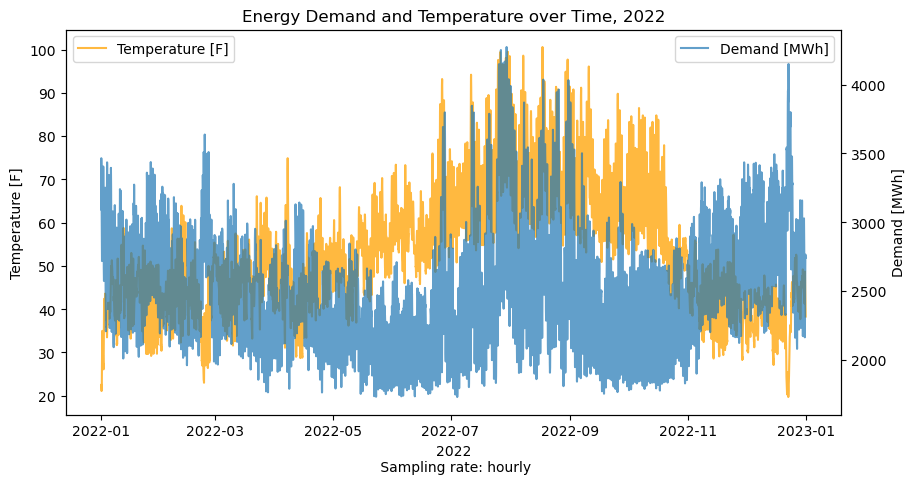

In [15]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
plt.title("Energy Demand and Temperature over Time, 2022")

ax1.plot(demand['time'], demand['temp'], label='Temperature [F]', color="#ffb940") # orange color
ax2.plot(demand['time'], demand['demand'], label='Demand [MWh]', alpha=0.7)

ax1.set_xlabel('2022\n Sampling rate: hourly')
ax1.set_ylabel('Temperature [F]')
ax2.set_ylabel('Demand [MWh]')

ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

## Energy Trends per Day, Week, and Month
Look at how the **demand per hour (DPH)** changes per hour of day, day of week, and month of year. 

### Calculate the average difference in min and max energy per day.  
Group the data by date, then look at the average difference between min and max values

In [149]:
energy_per_day = demand.groupby([demand.time.dt.date])['demand']
mean_change = (energy_per_day.max() - energy_per_day.min()).mean()
print(f'Range in energy demand per day: {mean_change.round(1)} MWh')

Range in energy demand per day: 946.1 MWh


### DPH by Month


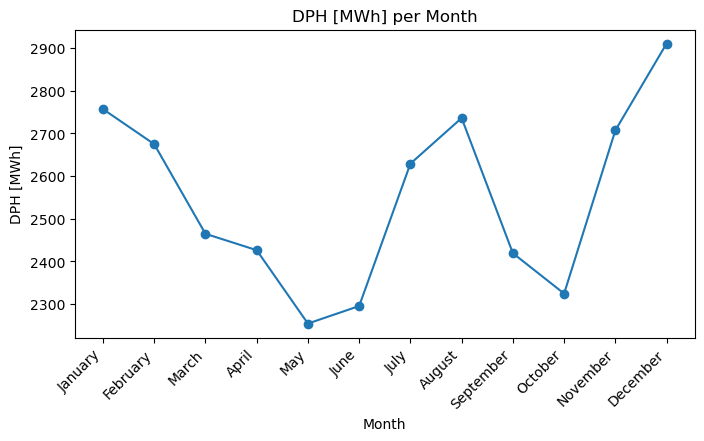

In [71]:
energy_per_month = demand.groupby([demand.time.dt.month])['demand'].mean()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(list(calendar.month_name[1:]), energy_per_month, marker='o')

ax.set(ylabel='DPH [MWh]', xlabel='Month')
plt.xticks(rotation=45, ha="right")
plt.title("DPH [MWh] per Month")
plt.show()

### DPH by Day of Week


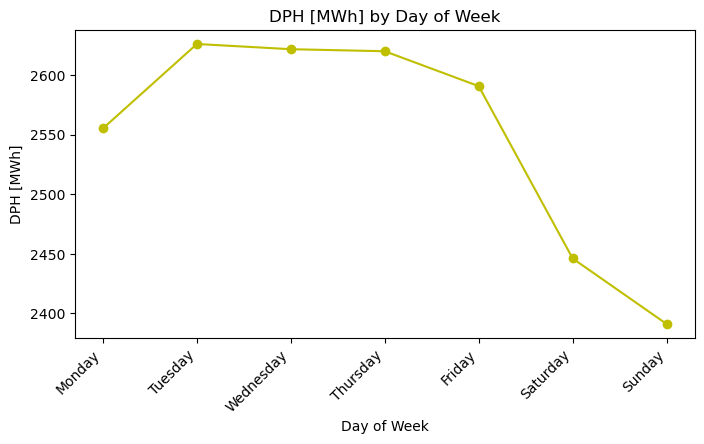

In [179]:
# In pandas, the day of the week has Monday=0, Sunday=6
energy_per_day_of_week = demand.groupby(demand.time.dt.dayofweek)['demand'].mean()
groups = demand.groupby([pd.Grouper(key='time', freq='W'), demand.time.dt.dayofweek])['demand'].mean().to_frame().groupby(by='time')

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(list(calendar.day_name), energy_per_day_of_week, marker='o', c='y')

ax.set(ylabel='DPH [MWh]', xlabel='Day of Week')
plt.xticks(rotation=45, ha="right")
plt.title("DPH [MWh] by Day of Week")
plt.show()

### Demand per Hour of Day

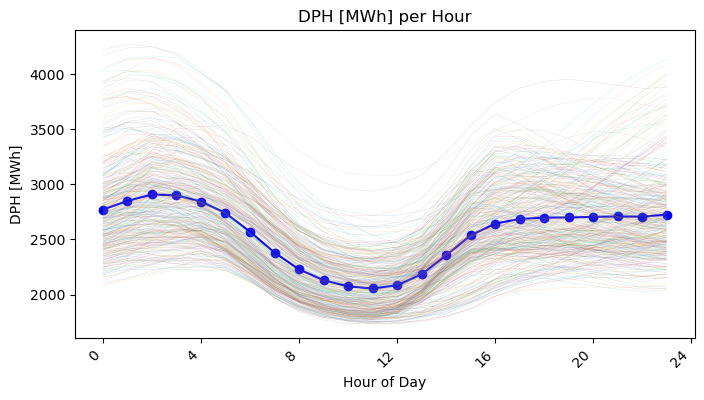

In [47]:
# In pandas, the day of the week has Monday=0, Sunday=6
energy_per_hour = demand.groupby(demand.time.dt.hour)['demand'].mean()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(energy_per_hour, marker='o', c='b')

for key, grp in demand.groupby([demand.time.dt.date])['demand']:
    ax.plot(grp.index.hour, grp, label=key,linewidth=0.1, alpha=0.6)

ax.set(ylabel='DPH [MWh]', xlabel='Hour of Day')
plt.xticks(np.arange(0, 25, 4).tolist(), rotation=45, ha="right")
plt.title("DPH [MWh] per Hour")
plt.show()

## Autocorrelation 
Check for periodicity (or not!) using autocorrelation plot.  
The lag will be by the hour. 

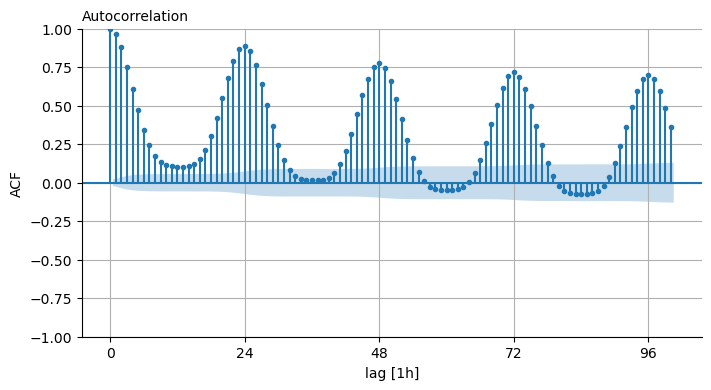

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
sm.graphics.tsa.plot_acf(demand['demand'], ax=ax, lags=100, markersize=3)
ax.set(ylim=(-1,1), xlabel='lag [1h]', ylabel='ACF')
ax.set_xticks(np.arange(0, 100, 24).tolist(), minor=False)
plt.grid()

Plot shows that demand from previous day is a good indicator of demand for next day (lag of 24 hours).  
Each observations is related to observations 24-times removed (one day later). 

## Time Series Decomposition for Energy Demand 

### Remove daily seasonality 

Taking the information from the lag chart, perform a STL decomposition (easonal and Trend decomposition using Loess) using a 24 hour period. 

Then, plot the remaining trend ontop of the original demand vs time curve. 

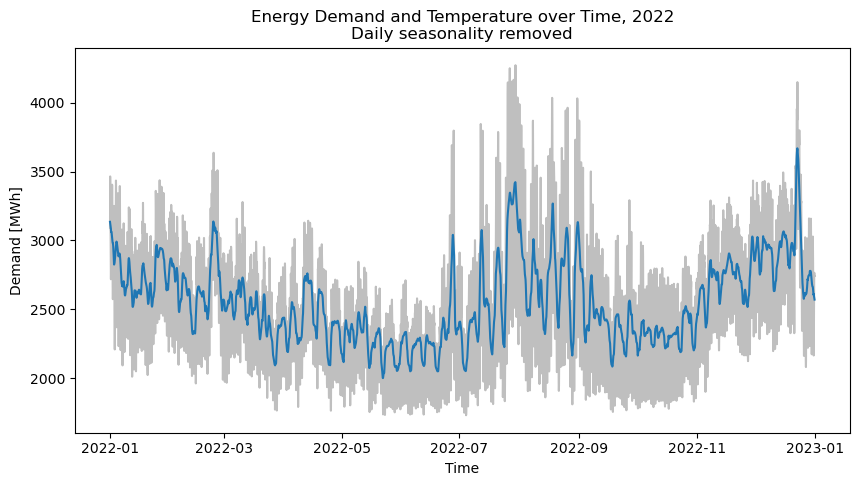

In [407]:
day_result = seasonal_decompose(demand['demand'], period=24, model='additive', extrapolate_trend='freq')

demand['day_trend'] = day_result.trend
demand['day_seasonal'] = day_result.seasonal
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(demand['time'], demand.demand, color='.5', alpha=.5)
ax.plot(demand['time'], demand['STL_day'])
ax.set(ylabel='Demand [MWh]', xlabel='Time')
plt.title("Energy Demand and Temperature over Time, 2022\nDaily seasonality removed")
plt.show()

### Autocorrelation without daily seasonality 

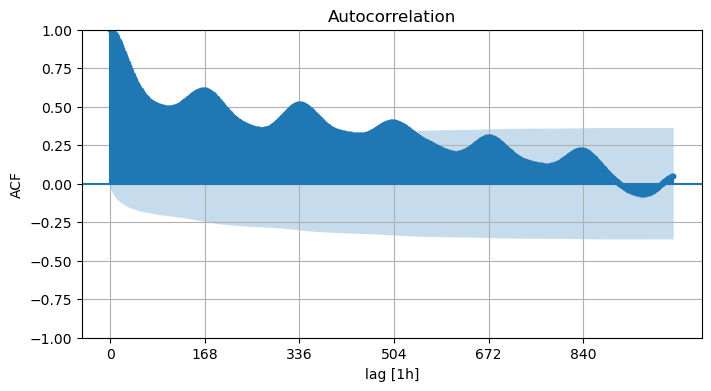

In [184]:
fig, ax = plt.subplots(figsize=(8,4))
sm.graphics.tsa.plot_acf(demand['STL_day'], ax=ax, lags=1000, markersize=3)
ax.set(ylim=(-1,1), xlabel='lag [1h]', ylabel='ACF')
ax.set_xticks(np.arange(0, 1000, 168).tolist(), minor=False)
plt.grid()

The above ACF plot shows there is still a large seasonal component, which indicates a weekly trend (every 168 hours = 1 week). 

### Remove weekly seasonality 

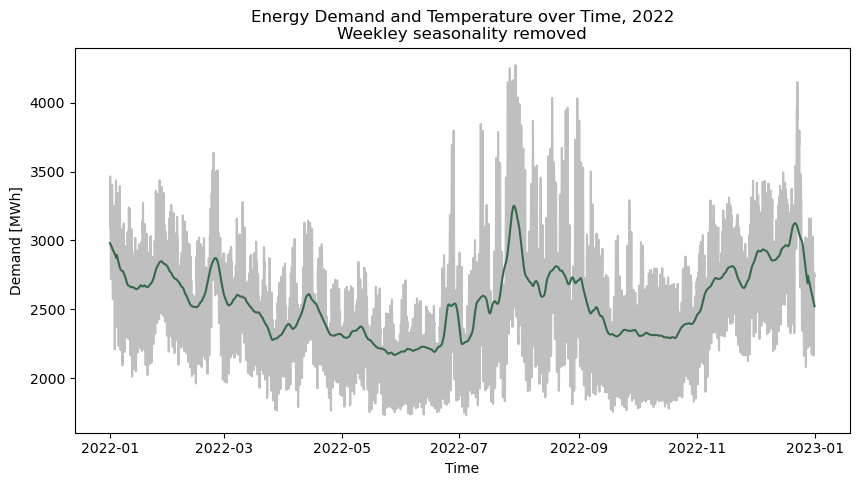

In [409]:
week_result = seasonal_decompose(demand['STL_day'], period=168, model='additive', extrapolate_trend='freq')
# result.plot()

demand['week_trend'] = week_result.trend
demand['week_seasonal'] = week_result.seasonal
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(demand['time'], demand.demand, color='.5', alpha=.5)
ax.plot(demand['time'], demand['STL_week'], color="#36694c")
ax.set(ylabel='Demand [MWh]', xlabel='Time')
plt.title("Energy Demand and Temperature over Time, 2022\nWeekley seasonality removed")
plt.show()

## Explore Correlation with Temperature
Below, we will explore how removing the sesonality of the data improves the correlation with temperature.

In the top plot (A), there is no clear relationship between temperature and demand. Especially at temperatures above 60°. 

In the bottom plot (B), there is a clear relationship between temperature and demand: 
- At very low temperatures, demand increases
- At very high temperatures, demand increases 
- There is a dip in demand at moderate temperatures 

In [502]:
# Create a polynomial fit for the bottom graph FOR VIEWING PURPOSES ONLY 
temp_x = demand['temp'].sort_values().values.reshape(-1,1)
demand_y = week_result.trend.values.reshape(-1,1)

transformer = PolynomialFeatures(degree=2, include_bias=False)
x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(temp_x)
model = LinearRegression().fit(x_, demand_y)

print(model.coef_)
quad_coef1, quad_coef2 = model.coef_[0]
quad_intercept = model.intercept_

[[-43.15987287   0.40566231]]


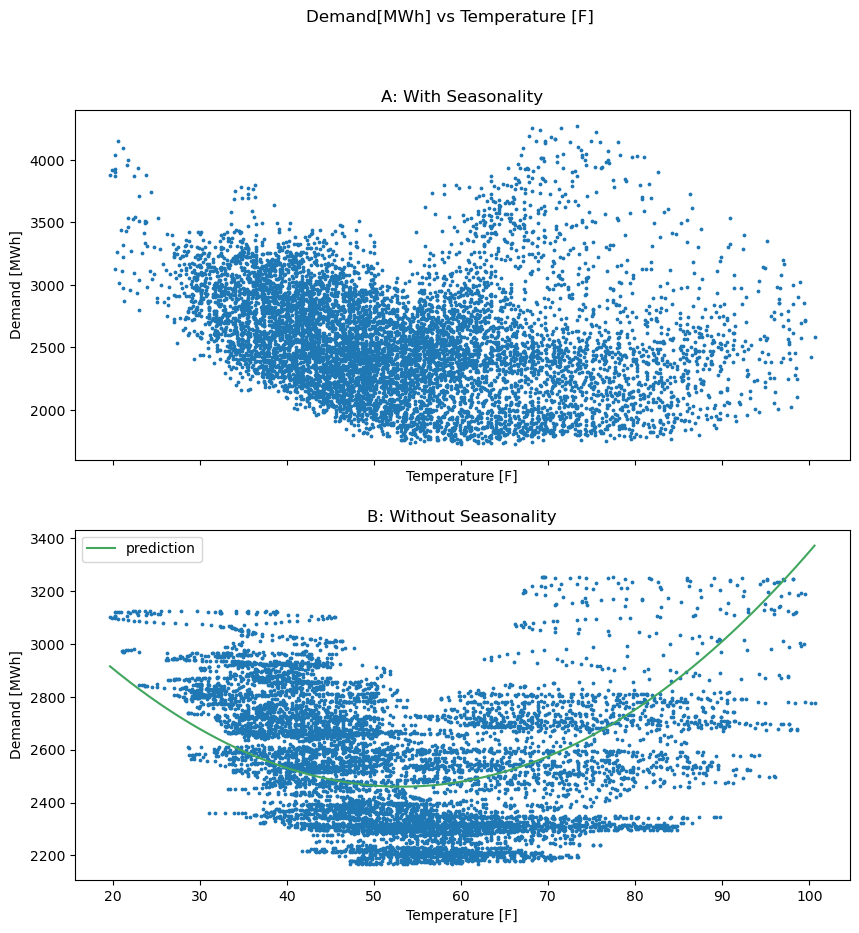

In [503]:
# Top plot
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,10))
ax1.scatter(demand.temp, demand.demand, s=3)
ax1.set_title('A: With Seasonality')
ax1.set_xlabel("Temperature [F]")
ax1.set_ylabel("Demand [MWh]")

# Bottom plot 
ax2.scatter(demand.temp, demand.STL_week, s=3)
ax2.set_title("B: Without Seasonality")
ax2.set_xlabel("Temperature [F]")
ax2.set_ylabel("Demand [MWh]")

ax2.plot(temp_x, (quad_coef1 * temp_x + 
                  quad_coef2* temp_x**2 + 
                  quad_intercept), label = 'prediction', color = "#42a65e")
plt.legend()
plt.suptitle('Demand[MWh] vs Temperature [F]')
plt.show()

## Check PGE's Demand Forecasing 
Let's check how good of a job PGE does forecsating their demand. 

NOTE: I believe the `Day-ahead demand forecast` values have already been appropriately shifted to be in the same row as the date they supposedly forecast for. 
I originally assumed they would need to be shifted to a day later. After manually shifting it, the R^2 value dropped from 0.98 to 0.74. 
Of course, they *may* need to be shifted, but I would be surprised if their R^2 value for forecasting was that low. 

In [1282]:
forecast.head(1)

,period,respondent,type-name,forecast,value-units,time,temp
2,2022-01-01,PGE,Day-ahead demand forecast,3448,megawatthours,2022-01-01,22.5


In [551]:
# Merge the demand and forecast tables for ease 
demand_forecast = forecast.merge(demand, how='inner', left_on='period', right_on='period')

In [1284]:
# demand array must be 2D, reshape() makes this nympy array 2D
# reshape is a numpy operator, so use .values to turn the pd series into a np array 
demand_x = demand_forecast['demand'].values.reshape(-1,1)
forecast_y = demand_forecast['forecast'].values.reshape(-1,1)
model = LinearRegression().fit(demand_x, forecast_y)
r_sq = model.score(demand_x, forecast_y)
print (f"R^2 value is {r_sq.round(3)}")

R^2 value is 0.98


Plot PGE's demand vs their forecasted demand on a scatter plot with the linear fit

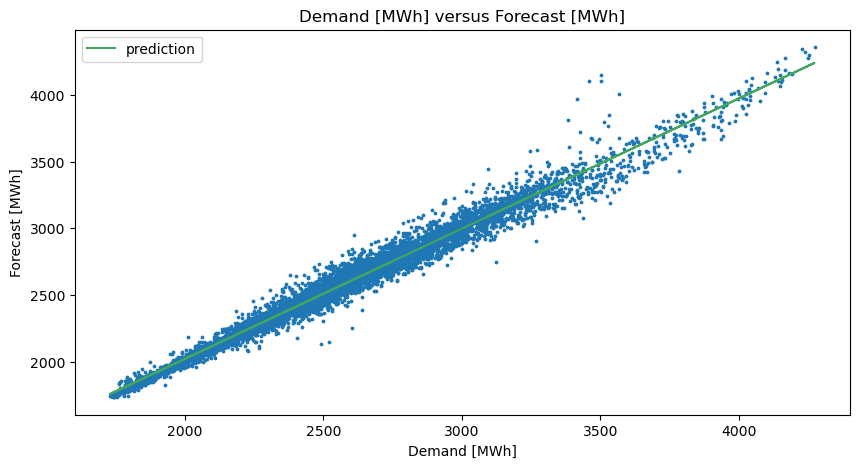

In [1285]:
plt.figure(figsize=(10,5))
plt.title('Demand [MWh] versus Forecast [MWh]')
plt.xlabel("Demand [MWh]")
plt.ylabel("Forecast [MWh]")
plt.scatter(demand_x, forecast_y, s=3)
plt.plot(demand_x, model.coef_ * demand_x + model.intercept_, label='prediction', color="#42a65e")

plt.legend()
plt.show()

## Compare to a seasonal naive model 
A seasonal naieve model sets the forecast to be equal to the last observed value of an equivalent season.  
EX: Forecast power usage this upcoming Saturday at noon to whatever it was last Saturday at noon.

For this seasonal naive model, the daily seasonality will be repeated. 

Lag will be set to 24 hours, and daily trends from the last observed day will be repeated for three days. 

In [14]:
# specificy the dataset and the lag 
s = TSNaiveSeasonal(demand.demand, 24)

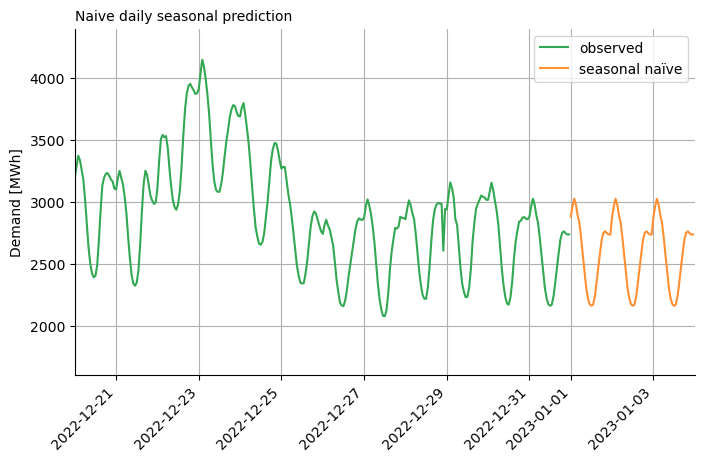

In [15]:
fig, ax = plt.subplots()
ax.plot(demand.demand, color='#32a852', label='observed') # green 
ax.plot(s.forecast(end='2023-01-03 23:00:00'), color='#ff8f33', label='seasonal naïve') # orange

plt.title('Naive daily seasonal prediction')
plt.ylabel("Demand [MWh]")

plt.xlim(dt.date(2022, 12, 20), dt.date(2023, 1, 4))
plt.xticks(rotation=45, ha="right")

ax.legend()
ax.grid()

# RANDOM EXPLORATORY STUFF

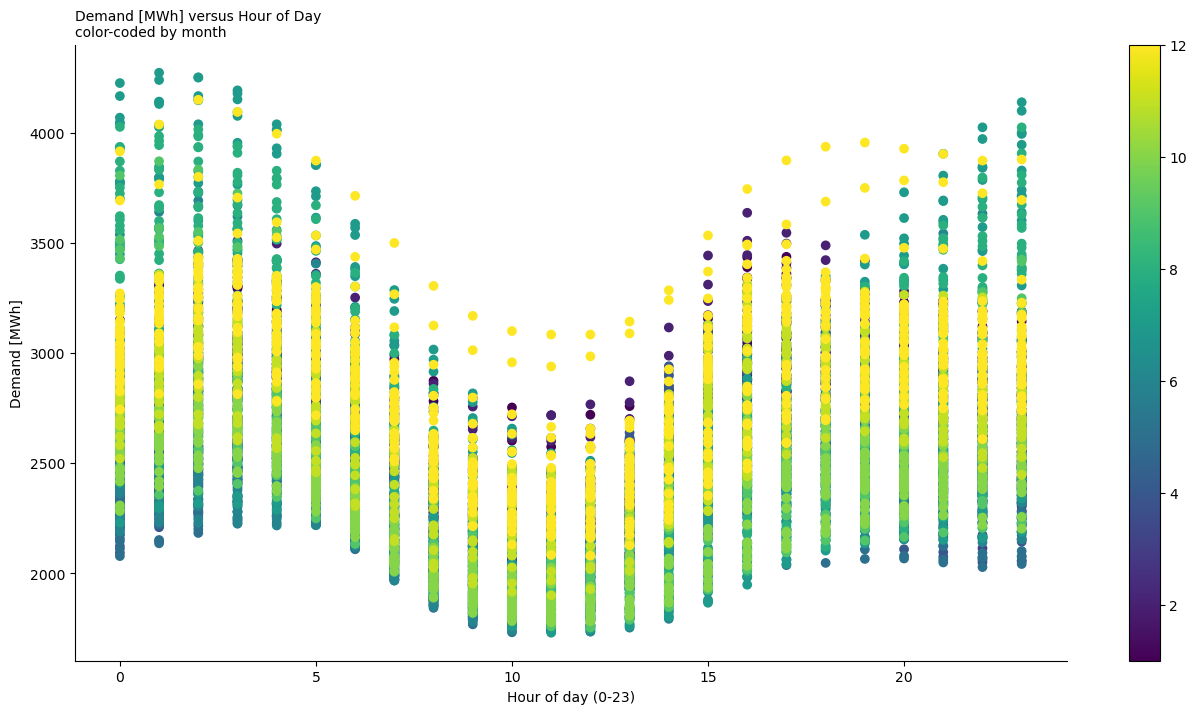

In [1550]:
plt.figure(figsize=(16,8))
plt.scatter(demand['time'].dt.hour, demand['demand'], c=demand['time'].dt.month)
plt.title('Demand [MWh] versus Hour of Day\ncolor-coded by month')
plt.xlabel("Hour of day (0-23)")
plt.ylabel("Demand [MWh]")
plt.colorbar()
# GET THIS TO FILL WITH COLOR BY SEASON INSTEAD, AND MAKE DISCRETE COLOR STEPS, AND LABEL THE COLORS! 

plt.show()


Daily trends show high energy consumption in morning and evening. 

Morning due to need for heating, evening due to need for cooling and lights 

## Creating a Model
There are a few obvious variables from looking at Fig 1 that should be investigated: 
- temperature
- week in the year (to account for seasonal fluctuations)
- time of day 
- day of week 
- season? 

It is clear that when temperatures are very high, or very low, energy demand increases due to need for heat or AC. 
When temperatures are moderate (spring and fall), energy demand falls, as likely many people do not run heat and AC as much. 

Temperature and demand are **not** homoscedastic -- the variance of the data is NOT the same over the time range. 

**3D plot showing temperature, demand, and hour of day**

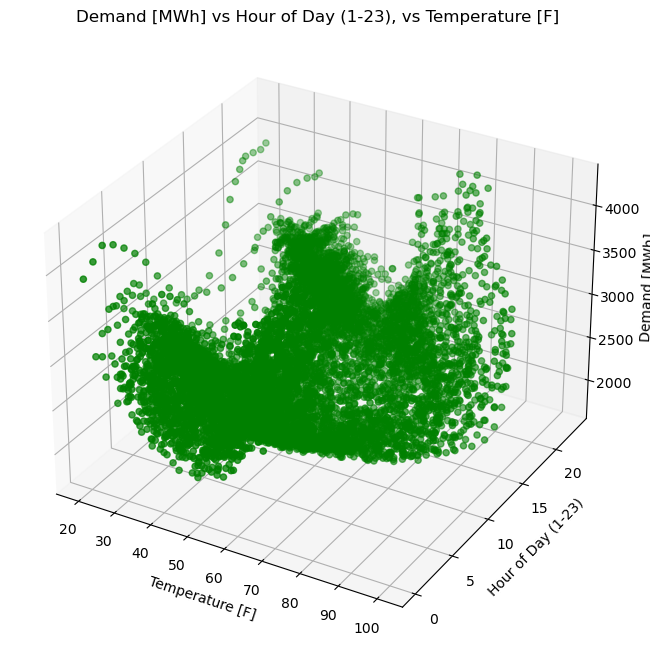

In [1289]:
plt.figure(figsize=(16,8))
# Creating dataset
z = demand['demand'].values
x = demand['temp'].values
y = demand['time'].dt.hour.values
 
# Creating figure
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color='g')
plt.title("Demand [MWh] vs Hour of Day (1-23), vs Temperature [F]")
ax.set_xlabel('Temperature [F]')
ax.set_ylabel('Hour of Day (1-23)')
ax.set_zlabel('Demand [MWh]')

plt.show()

### Messing around with some ugly multivariate regression 

In [377]:
# In pandas, the day of the week has Monday=0, Sunday=6
demand_for_fit = demand.copy()
demand_for_fit['day_of_week'] = demand_for_fit.time.dt.dayofweek
demand_for_fit['hour_of_day'] = demand_for_fit.time.dt.hour


In [379]:
# Multivariate linear regression model to fit the demand value 
fit = smf.ols('demand ~ temp + day_of_week + hour_of_day', demand_for_fit).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     264.5
Date:                Sat, 11 Feb 2023   Prob (F-statistic):          2.50e-164
Time:                        12:57:28   Log-Likelihood:                -65237.
No. Observations:                8760   AIC:                         1.305e+05
Df Residuals:                    8756   BIC:                         1.305e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3033.5037     18.447    164.445      0.000    2997.343    3069.664
temp           -7.2921      0.305    -23.883      0.000      -7.891      -6.694
day_of_week   -32.1264      2.218    -14.488      0.000     -36.473     -27.780
hour_of_day     0.1772      0.653      0.271      0.786      -1.103       1.458
==============================================================================
Omnibus:                     1060.832   Durbin-Watson:                   0.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1760.400
Skew:                           0.837   Prob(JB):                         0.00
Kurtosis:                       4.421   Cond. No.                         236.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

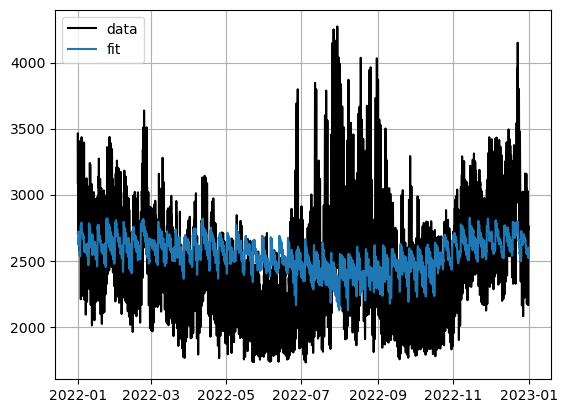

In [401]:
fig, ax = plt.subplots()
ax.plot(demand_for_fit.demand, label='data', color='k')
ax.plot(demand_for_fit.index, fit.predict(), label='fit')
ax.legend()
ax.grid()

In [390]:
df_dw = demand.copy()

df_dw['M'] = np.where(df_dw.time.dt.dayofweek  == 0, 1, 0)
df_dw['Tu'] = np.where(df_dw.time.dt.dayofweek == 1, 1, 0)
df_dw['W'] = np.where(df_dw.time.dt.dayofweek  == 2, 1, 0)
df_dw['Th'] = np.where(df_dw.time.dt.dayofweek == 3, 1, 0)
df_dw['F'] = np.where(df_dw.time.dt.dayofweek  == 4, 1, 0)
df_dw['Sa'] = np.where(df_dw.time.dt.dayofweek == 5, 1, 0)

df_dw['00'] = np.where(df_dw.time.dt.hour == 0, 1, 0)
df_dw['01'] = np.where(df_dw.time.dt.hour == 1, 1, 0)
df_dw['02'] = np.where(df_dw.time.dt.hour == 2, 1, 0)
df_dw['03'] = np.where(df_dw.time.dt.hour == 3, 1, 0)
df_dw['04'] = np.where(df_dw.time.dt.hour == 4, 1, 0)
df_dw['05'] = np.where(df_dw.time.dt.hour == 5, 1, 0)
df_dw['06'] = np.where(df_dw.time.dt.hour == 6, 1, 0)
df_dw['07'] = np.where(df_dw.time.dt.hour == 7, 1, 0)
df_dw['08'] = np.where(df_dw.time.dt.hour == 8, 1, 0)
df_dw['09'] = np.where(df_dw.time.dt.hour == 9, 1, 0)
df_dw['10'] = np.where(df_dw.time.dt.hour == 10, 1, 0)
df_dw['11'] = np.where(df_dw.time.dt.hour == 11, 1, 0)
df_dw['12'] = np.where(df_dw.time.dt.hour == 12, 1, 0)
df_dw['13'] = np.where(df_dw.time.dt.hour == 13, 1, 0)
df_dw['14'] = np.where(df_dw.time.dt.hour == 14, 1, 0)
df_dw['15'] = np.where(df_dw.time.dt.hour == 15, 1, 0)
df_dw['16'] = np.where(df_dw.time.dt.hour == 16, 1, 0)
df_dw['17'] = np.where(df_dw.time.dt.hour == 17, 1, 0)
df_dw['18'] = np.where(df_dw.time.dt.hour == 18, 1, 0)
df_dw['19'] = np.where(df_dw.time.dt.hour == 19, 1, 0)
df_dw['20'] = np.where(df_dw.time.dt.hour == 20, 1, 0)
df_dw['21'] = np.where(df_dw.time.dt.hour == 21, 1, 0)
df_dw['22'] = np.where(df_dw.time.dt.hour == 22, 1, 0)



In [399]:
# Multivariate linear regression model to fit the demand value 
fit2 = smf.ols('demand ~ temp + M + Tu + W + Th + F + Sa + Q("00")+ Q("01")+ Q("02")+ Q("03")+ Q("04")+ Q("05")+ Q("06")+ Q("07")+ Q("08")+ Q("09")+ Q("10") + Q("11") + Q("12") + Q("13") + Q("14") + Q("15") + Q("16") + Q("17") + Q("18") + Q("19") + Q("20") + Q("21") + Q("22")', df_dw).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     264.2
Date:                Sat, 11 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:02:00   Log-Likelihood:                -62787.
No. Observations:                8760   AIC:                         1.256e+05
Df Residuals:                    8729   BIC:                         1.259e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2804.4591     22.118    126.798      0.000    2761.103    2847.815
temp          -4.6965      0.244    -19.257      0.000      -5.175      -4.218
M            163.1921     12.582     12.970      0.000     138.529     187.855
Tu           234.6819     12.582     18.653      0.000     210.019     259.345
W            229.4303     12.582     18.235      0.000     204.767     254.094
Th           225.7895     12.583     17.944      0.000     201.124     250.455
F            195.7990     12.583     15.560      0.000     171.133     220.465
Sa            49.9869     12.525      3.991      0.000      25.435      74.539
Q("00")       40.9633     23.266      1.761      0.078      -4.643      86.570
Q("01")      115.8721     23.268      4.980      0.000      70.261     161.484
Q("02")      171.4544     23.271      7.368      0.000     125.837     217.071
Q("03")      161.8017     23.274      6.952      0.000     116.179     207.424
Q("04")      103.6598     23.277      4.453      0.000      58.032     149.288
Q("05")       -2.6441     23.280     -0.114      0.910     -48.278      42.989
Q("06")     -171.2737     23.278     -7.358      0.000    -216.905    -125.643
Q("07")     -355.3237     23.270    -15.269      0.000    -400.939    -309.709
Q("08")     -498.3116     23.265    -21.419      0.000    -543.916    -452.707
Q("09")     -583.6632     23.274    -25.078      0.000    -629.286    -538.040
Q("10")     -626.5050     23.304    -26.884      0.000    -672.187    -580.823
Q("11")     -635.6325     23.340    -27.233      0.000    -681.385    -589.880
Q("12")     -597.2324     23.384    -25.540      0.000    -643.070    -551.394
Q("13")     -491.4374     23.422    -20.982      0.000    -537.349    -445.525
Q("14")     -315.0898     23.446    -13.439      0.000    -361.050    -269.129
Q("15")     -133.8358     23.450     -5.707      0.000    -179.803     -87.869
Q("16")      -28.8682     23.431     -1.232      0.218     -74.798      17.062
Q("17")        5.9804     23.391      0.256      0.798     -39.871      51.832
Q("18")        9.6790     23.347      0.415      0.678     -36.087      55.445
Q("19")        1.2105     23.309      0.052      0.959     -44.481      46.902
Q("20")       -3.6154     23.283     -0.155      0.877     -49.256      42.025
Q("21")       -7.7485     23.271     -0.333      0.739     -53.364      37.867
Q("22")      -16.3060     23.266     -0.701      0.483     -61.912      29.300
==============================================================================
Omnibus:                     1686.915   Durbin-Watson:                   0.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3590.137
Skew:                           1.127   Prob(JB):                         0.00
Kurtosis:                       5.181   Cond. No.                     1.36e+03
==

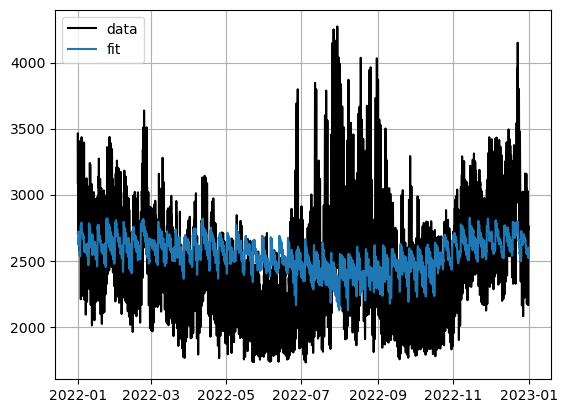

In [400]:
fig, ax = plt.subplots()
ax.plot(df_dw.demand, label='data', color='k')
ax.plot(df_dw.index, fit.predict(), label='fit')
ax.legend()
ax.grid()

### Doing some semi-made up seasonal + trend forecasting 
Plan: 
- Creat a model that is composed of daily_seaonality + weekly_seasonality + trend
- Where trend is predicted using the temperature (and a quadratic equation) 
- Use the first 80% of the data as the test set 
- Use the last 20% of the data to check your model against 


- Compare to a seasonal naive model of only forcasting using the daily_seasonality 


In [568]:
# Split the data sets into 80% test, 20% check
test = demand['2022-01-01 00:00:00' : '2022-10-21 00:00:00']
check = demand['2022-10-21 00:00:00' : '2022-12-31 23:00:00']

In [446]:
test.head(2)

,respondent,type-name,demand,value-units,time,temp,STL_day,STL_week,day_trend,day_seasonal,week_trend,week_seasonal
period,,,,,,,,,,,,
2022-01-01 00:00:00,PGE,Demand,3093,megawatthours,2022-01-01 00:00:00,22.5,3135.116803,2979.790538,3135.116803,221.487154,2979.790538,1.353044
2022-01-01 01:00:00,PGE,Demand,3272,megawatthours,2022-01-01 01:00:00,22.1,3130.615489,2978.465956,3130.615489,299.959132,2978.465956,-3.777044


In [464]:
# specificy the dataset and the lag 
week_naive = TSNaiveSeasonal(test.week_seasonal, 168)
week_forecast = week_naive.forecast(end='2022-12-31 23:00:00')

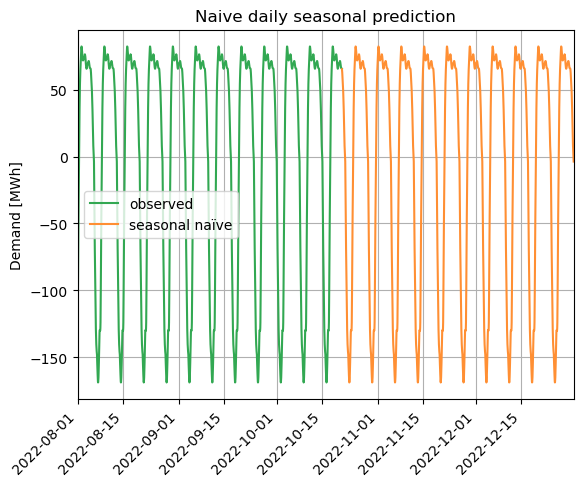

In [465]:
fig, ax = plt.subplots()
ax.plot(test.week_seasonal, color='#32a852', label='observed') # green 
ax.plot(week_naive.forecast(end='2022-12-31 23:00:00'), color='#ff8f33', label='seasonal naïve') # orange

plt.title('Naive daily seasonal prediction')
plt.ylabel("Demand [MWh]")

plt.xlim(dt.date(2022, 8, 1), dt.date(2022, 12, 31))
plt.xticks(rotation=45, ha="right")

ax.legend()
ax.grid()

In [466]:
# specificy the dataset and the lag 
day_naive = TSNaiveSeasonal(test.day_seasonal, 24)
day_forecast = day_naive.forecast(end='2022-12-31 23:00:00')

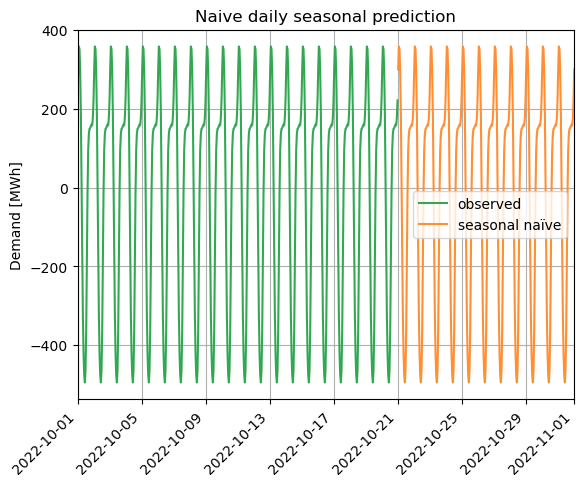

In [467]:
fig, ax = plt.subplots()
ax.plot(test.day_seasonal, color='#32a852', label='observed') # green 
ax.plot(day_naive.forecast(end='2022-12-31 23:00:00'), color='#ff8f33', label='seasonal naïve') # orange

plt.title('Naive daily seasonal prediction')
plt.ylabel("Demand [MWh]")

plt.xlim(dt.date(2022, 10, 1), dt.date(2022, 11, 1))
plt.xticks(rotation=45, ha="right")

ax.legend()
ax.grid()

In [473]:

predictions = pd.concat([day_forecast, week_forecast],axis=0).to_frame()

In [535]:
temp = demand['2022-10-21 00:00:00' : '2022-12-31 23:00:00']['temp']
d_forecast = pd.concat([day_forecast, week_forecast, temp ], axis =1).rename(columns={0:'day_forecast', 1:'week_forecast'})
d_forecast

,day_forecast,week_forecast,temp
2022-10-21 00:00:00,NaN,NaN,54.4
2022-10-21 01:00:00,299.959132,65.149656,52.3
2022-10-21 02:00:00,358.271464,64.151911,53.6
2022-10-21 03:00:00,350.808511,62.535687,51.5
2022-10-21 04:00:00,294.492362,60.721410,50.6
...,...,...,...
2022-12-31 19:00:00,151.043297,-142.550346,41.4
2022-12-31 20:00:00,156.092863,-144.300137,39.9
2022-12-31 21:00:00,159.947737,-145.603624,39.2
2022-12-31 22:00:00,158.051926,-146.723012,38.5


In [536]:

d_forecast['temp_forecast'] = quad_coef1 * d_forecast.temp + quad_coef2* d_forecast.temp**2 + quad_intercept

In [537]:
d_forecast

,day_forecast,week_forecast,temp,temp_forecast
2022-10-21 00:00:00,NaN,NaN,54.4,2460.673472
2022-10-21 01:00:00,299.959132,65.149656,52.3,2460.412451
2022-10-21 02:00:00,358.271464,64.151911,53.6,2460.152147
2022-10-21 03:00:00,350.808511,62.535687,51.5,2461.254151
2022-10-21 04:00:00,294.492362,60.721410,50.6,2462.821727
...,...,...,...,...
2022-12-31 19:00:00,151.043297,-142.550346,41.4,2516.539976
2022-12-31 20:00:00,156.092863,-144.300137,39.9,2531.809266
2022-12-31 21:00:00,159.947737,-145.603624,39.2,2539.559655
2022-12-31 22:00:00,158.051926,-146.723012,38.5,2547.707593


In [538]:
d_forecast['sum'] = d_forecast.day_forecast + d_forecast.week_forecast + d_forecast.temp_forecast
d_forecast.tail()

,day_forecast,week_forecast,temp,temp_forecast,sum
2022-12-31 19:00:00,151.043297,-142.550346,41.4,2516.539976,2525.032927
2022-12-31 20:00:00,156.092863,-144.300137,39.9,2531.809266,2543.601992
2022-12-31 21:00:00,159.947737,-145.603624,39.2,2539.559655,2553.903768
2022-12-31 22:00:00,158.051926,-146.723012,38.5,2547.707593,2559.036506
2022-12-31 23:00:00,177.701435,-147.817609,38.3,2550.108594,2579.992421


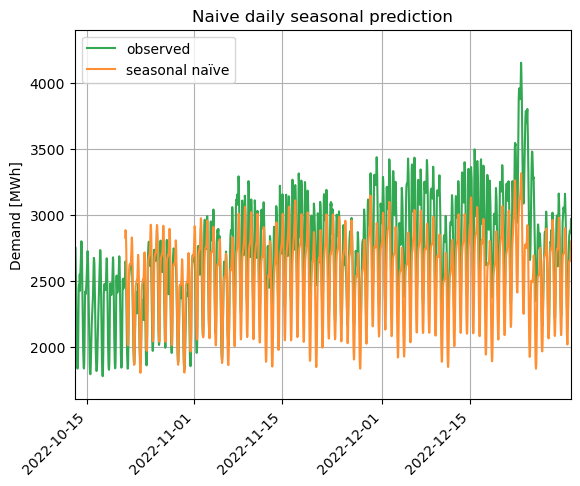

In [527]:
fig, ax = plt.subplots()
ax.plot(demand.demand, color='#32a852', label='observed') # green 
ax.plot(forecast['sum'], color='#ff8f33', label='seasonal naïve') # orange

plt.title('Naive daily seasonal prediction')
plt.ylabel("Demand [MWh]")

plt.xlim(dt.date(2022, 10, 13), dt.date(2022, 12, 31))
plt.xticks(rotation=45, ha="right")

ax.legend()
ax.grid()

Forecast could probably be improved with a piecewise function for the temperature 


**PGE only forecasts 1 day in advance. Do a 1-day forecast and check the hourly demand against what PGE forecast.**